## Analysing A subset of data from Experiment 68 (166K-member Level 3 library)

- Python version


In [1]:
from Bio import SeqIO, Align
from Bio.Seq import Seq
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wimpy as wp

%load_ext autoreload
%autoreload 2


### Loading input data

Reference sequences

In [2]:
# reference sequences from input fasta file
with open(r"./info/ref_sequences.fasta") as ref_fasta_file:
    ref_seqs = {
        record.id: str(record.seq) for record in SeqIO.parse(ref_fasta_file, "fasta")
    }
    
Puro = ref_seqs['Puro']
GFP = ref_seqs['GFP'][-100:]
A4 = ref_seqs['A4'][-50:]
minP = ref_seqs['minP']
mRuby = ref_seqs['mRuby'][200:300]
BFP = ref_seqs['BFP'][200:300]
ZF_parts = [ref_seqs['WT'], ref_seqs['C1_WT'], ref_seqs['C1_6x']]

# reference sequences from excel files
minP_100k = pd.read_excel(r'./info/100k_Minimal-Promoters.xlsx')['Sequence'].to_list()
terminators_100k = pd.read_excel(r'./info/100k_Terminators.xlsx')['Sequence'].to_list()
promoters_100k = pd.read_excel(r'./info/100k-Promoters.xlsx')['Sequence'].to_list()
ORF_parts = pd.read_excel(r'./info/100k_ORF-Parts_SynTF.xlsx')['SEQUENCE'].to_list()
AD_parts, IDR_parts = ORF_parts[0:4], ORF_parts[4:8]


In [3]:
pd.read_excel(r'./info/100k_Terminators.xlsx')

,Unnamed: 0,Terminator,Sequence
0,NaN,SV40,AACTTGTTTATTGCAGCTTATAATGGTTACAAATAAAGCAATAGCA...
1,NaN,SV40 + 250bp,AACTTGTTTATTGCAGCTTATAATGGTTACAAATAAAGCAATAGCA...
2,NaN,SV40 + 500bp,AACTTGTTTATTGCAGCTTATAATGGTTACAAATAAAGCAATAGCA...
3,NaN,sT1A18,ccatatcttggagggagagtaggtatttgtgatttgtgtattattt...
4,NaN,sT1A18 + 250bp,CCATATCTTGGAGGGAGAGTAGGTATTTGTGATTTGTGTATTATTT...
5,NaN,sT1A18 + 500bp,CCATATCTTGGAGGGAGAGTAGGTATTTGTGATTTGTGTATTATTT...
6,NaN,T1A9,atcttttggactgggacgcgggattcttaccaatgctttgtgtaaa...
7,NaN,T1A9 + 250bp,CCATATCTTTTGGACTGGGACGCGGGATTCTTACCAATGCTTTGTG...
8,NaN,T1A9 + 500bp,CCATATCTTTTGGACTGGGACGCGGGATTNTTACCAATGCTTTGTG...
9,NaN,bGH225,ctgtgccttctagttgccagccatctgttgtttgcccctcccccgt...


Loading input Nanopore sequencing files, initial aliment with `bowtile`, and filter based on read length

In [4]:
# load in data
_, l, seqs = wp.fastqall('./fastq/')
l, seqs = np.array(l), np.array(seqs)

# filter based on read length
seqs = seqs[(l > 9500) & (l < 15000)]
l = l[(l > 9500) & (l < 15000)]


reading fastq files: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


In [5]:
# bowtile for alignment
new_seq, _, _ = wp.bowtile(seqs, Puro, thresh=0.03)
new_seq = np.array(new_seq)

# filter out failed attempts
reads_correct = new_seq[new_seq != '']
l_reads_correct = l[new_seq != '']
num_seqs = len(reads_correct)

bowtile progress: 100%|██████████| 11063/11063 [01:03<00:00, 172.92it/s]


### Reporter Identification

Locate A4, GFP, and Minimal Promoter region via TILING

In [6]:
_, positions_GFP, _ = wp.tilepin_v2(reads_correct, GFP, thresh=0.03, verbose=True)
_, positions_mRuby, _ = wp.tilepin_v2(reads_correct, mRuby, thresh=0.03, verbose=True)
_, positions_A4, _ = wp.tilepin_v2(reads_correct, A4, thresh=0.03, verbose=True)
_, positions_minP, _ = wp.tilepin_v2(reads_correct, minP, thresh=0.03, verbose=True)
_, positions_BFP, _ = wp.tilepin_v2(reads_correct, BFP, thresh=0.03, verbose=True)

match sequences to reference: 100%|██████████| 11025/11025 [00:08<00:00, 1353.67it/s]


Assessing reporter diversity

In [7]:
# pregions and tregions using chophat
p_regions = wp.chophat(reads_correct, positions_A4, end_positions=positions_GFP)
t_regions = wp.chophat(reads_correct, positions_GFP, max_length=2000)


Assign minimal promoters

In [8]:
thresh = 0.2
minP_match_ratios, _ = wp.viscount(p_regions, minP_100k, thresh, tile_len=6, verbose=True, return_confusion_matrix=False)
minP_variants = np.argmax(minP_match_ratios, axis=1)
minP_variants[np.sum(minP_match_ratios, axis=1) < thresh] = -1

matching to reference sequences: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Assign number of binding sites based on the length of sequence

In [9]:
bs_variants = np.zeros(num_seqs) - 1
dist = positions_minP - positions_A4
bs_variants[(dist > 0) & (dist < 160)] = 0 # 2 binding sites
bs_variants[(dist > 160) & (dist < 255)] = 1 # 4 binding sites
bs_variants[(dist > 255) & (dist < 415)] = 2 # 8 binding sites
bs_variants[(dist > 415) & (dist < 555)] = 3 # 12 binding sites


Assign terminators

In [10]:
_, term_variants_counts = wp.viscount(t_regions, terminators_100k, 0.2, return_confusion_matrix=False, verbose=True)

# custom scaling of terminators
term_variants_counts_adjusted = np.zeros((num_seqs, 3))
term_variants_counts_adjusted[:, 0] = term_variants_counts[:, 0]
term_variants_counts_adjusted[:, 1] = term_variants_counts[:, 1] - term_variants_counts[:, 0] * 1.5
term_variants_counts_adjusted[:, 2] = term_variants_counts[:, 2] - term_variants_counts[:, 1]
term_variants_counts_adjusted[term_variants_counts_adjusted < 10] = -1

term_variants = np.argmax(term_variants_counts_adjusted, axis=1)
term_variants[np.sum(term_variants_counts_adjusted, axis=1) < 1] = -1


matching to reference sequences: 100%|██████████| 12/12 [01:13<00:00,  6.09s/it]


Combine assignment for the reporter

In [11]:
reporter_variants = np.stack([bs_variants, minP_variants, term_variants]).T

### SynTF Identification

Promoters

In [12]:
thresh = 0.03
pregions_synTF = wp.chophat(reads_correct, np.zeros_like(positions_minP), positions_minP)
synTF_prom_match_ratios, _, synTF_prom_conf = wp.viscount(pregions_synTF, promoters_100k, thresh=thresh, verbose=True)
synTF_prom_variants = np.argmax(synTF_prom_match_ratios, axis=1)
synTF_prom_variants[np.sum(synTF_prom_match_ratios, axis=1) < thresh] = -1

matching to reference sequences: 100%|██████████| 4/4 [01:59<00:00, 29.80s/it]


ORF parts

In [13]:
AD_count, AD_match = [], []
for AD_part in AD_parts:
    count, _, match = wp.tilepin_v2(pregions_synTF, AD_part, thresh=1, verbose=True)
    AD_count.append(count)
    AD_match.append(match)
AD_count, AD_match = np.array(AD_count), np.array(AD_match)

# Match mRuby index to AD indices
mRuby_count, _, mRuby_match = wp.tilepin_v2(pregions_synTF, mRuby[:50], thresh=1, verbose=True)


match sequences to reference: 100%|██████████| 11025/11025 [00:03<00:00, 2812.47it/s]


In [14]:
# activation domain confusion matrix
AD_conf = np.zeros((len(AD_parts), len(AD_parts)))

for i in range(len(AD_parts)):
    for j in range(len(AD_parts)):
        AD_conf[i, j] = np.sum((AD_count[i, :] > 30) & (AD_count[j, :] > 30))

# sequence-specific adjustments
AD_conf[3, 3] = np.sum((AD_count[3, :] > 10) & (AD_count[2, :] < 100))
AD_conf[2, 2] = np.sum(AD_count[2, :] > 100)
AD_conf[2, 3] = np.sum((AD_count[3, :] < 10) & (AD_count[2, :] > 100))
AD_conf[3, 2] = AD_conf[2, 3]

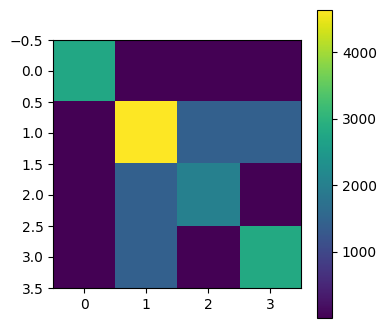

In [15]:
plt.figure(figsize=(4, 4))
plt.imshow(AD_conf)
plt.colorbar()
plt.show()

Assigning AD variants

In [16]:
AD_count[AD_count < 30] = 0
AD_variants = np.argmax(AD_count, axis=0)
AD_variants[np.sum(AD_count, axis=0) == 0] = -1


Identifying end position of AD for each read

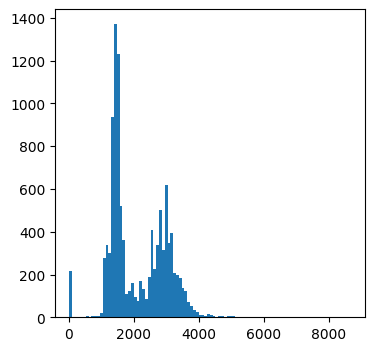

In [17]:
# Initialize array to store activation domain positions
AD_position = np.zeros(num_seqs)

for i in range(num_seqs):
    if AD_variants[i] >= 0:
        # Extract matched positions for the assigned activation domain variant
        matches = AD_match[AD_variants[i]][i, :]
        pos_matches = np.arange(len(matches))[matches == 1]
        # Check if there are sufficient matches to compute the mean
        if len(pos_matches) > 10:
            AD_position[i] = np.floor(np.mean(pos_matches[-10:]))

# visualize AD positions
plt.figure(figsize=(4, 4))
plt.hist(AD_position, bins=100)
plt.show()

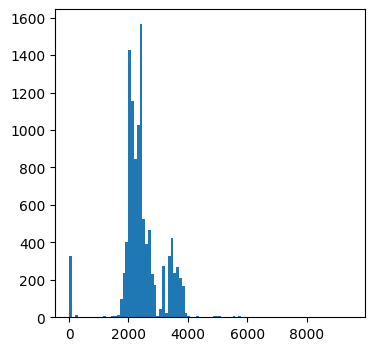

In [18]:
mRuby_position = np.zeros(num_seqs)
for i in range(num_seqs):
    x = mRuby_match
    
for i in range(num_seqs):
    # Extract matched positions for the assigned activation domain variant
    matches = mRuby_match[i, :]
    pos_matches = np.arange(len(matches))[matches == 1]
    # Check if there are sufficient matches to compute the mean
    if len(pos_matches) > 4:
        mRuby_position[i] = np.floor(np.mean(pos_matches))
        
# visualize mRuby positions
plt.figure(figsize=(4, 4))
plt.hist(mRuby_position, bins=100)
plt.show()

### Identify IDRs in synTF_pregion using tiling


In [19]:
IDR_len = mRuby_position - AD_position
IDR_tiles, _, IDR_conf = wp.viscount(
    pregions_synTF, 
    IDR_parts, 
    tile_len=10, 
    thresh=0.03, 
    return_confusion_matrix=True, 
    verbose=True
)

IDR_variants = np.argmax(IDR_tiles, axis=1) + 1
IDR_variants[(IDR_len < 500) & (IDR_len > 150)] = 0

# visualize confusion matrix
# plt.figure(figsize=(4, 4))
# plt.imshow(IDR_conf)
# plt.show()

matching to reference sequences: 100%|██████████| 4/4 [02:17<00:00, 34.33s/it]


matching to reference sequences: 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]


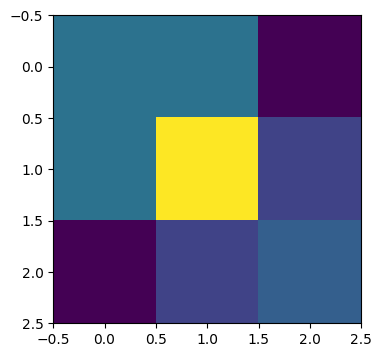

In [20]:
# Analyze Zinc Fingers
tregions_synTF = wp.chophat(reads_correct, positions_mRuby, end_positions=positions_A4)
ZF_tiles, _, ZF_conf = wp.viscount(tregions_synTF, ref_seqs=ZF_parts, thresh=0.03, tile_len=10, verbose=True)

ZF_variants = np.argmax(ZF_tiles, axis=1)
ZF_variants[np.sum(ZF_tiles, axis=1) == 0] = -1

# visualize confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(ZF_conf)
plt.show()

In [21]:
# Analyze terminators using viscount
_, term_synTF_match_counts, _ = wp.viscount(
    tregions_synTF, 
    ref_seqs=terminators_100k, 
    thresh=0.03, 
    tile_len=10, 
    return_confusion_matrix=True, 
    verbose=True
)

# Initialize the scaled terminator variants
term_synTF_match_counts_scaled = np.zeros_like(term_synTF_match_counts)
threshold = 10
key_indices = [0, 3, 6, 9] 

# Process terminator variants
for i in range(num_seqs):  # Loop through rows (each variant)
    for k in key_indices:
        if term_synTF_match_counts[i, k] < threshold: continue

        term_synTF_match_counts_scaled[i, k] = term_synTF_match_counts[i, k]
        term_synTF_match_counts_scaled[i, k + 1] = term_synTF_match_counts[i, k + 1] - 175
        term_synTF_match_counts_scaled[i, k + 2] = term_synTF_match_counts[i, k + 2] - 350

# Determine indices of maximum scaled terminator variants
term_synTF_variants = np.argmax(term_synTF_match_counts_scaled, axis=1)

# Adjust indices based on summed thresholds
term_synTF_variants[np.sum(term_synTF_match_counts[:, key_indices], axis=1) < 20] = -1

# Calculate assignments for synTF variants
synTF_variants = np.stack([
    synTF_prom_variants,
    AD_variants,
    IDR_variants,
    ZF_variants,
    term_synTF_variants
]).T


matching to reference sequences: 100%|██████████| 12/12 [02:04<00:00, 10.40s/it]


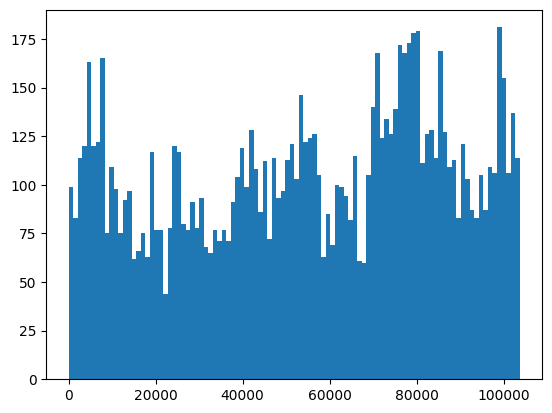

In [22]:
all_100k_variants = np.concatenate([synTF_variants, reporter_variants], axis=1)
library_100k = all_100k_variants @ np.array([1, 4, 16, 80, 240, 2880, 11520, 34560]).T
library_100k[np.any(all_100k_variants < 0, axis=1)] = -1

# visualize library balance
plt.figure()
plt.hist(library_100k[library_100k >= 0], bins=100)
plt.show()

### Barcoding & Barcoded AssTable Generation

In [23]:
tregion_BFP = wp.chophat(reads_correct, positions_BFP, max_length=1000, retain=True)
# load barcode structure and BLOSUM62 matrix
bba_construct = Seq("ATTATTATTATTATTATTA")
bba_sub_matrix = Align.substitution_matrices.Array(
    data=np.array([[5, -5, -5, -5], [-5, 5, 5, 5], [-5, 5, 5, 5], [-5, 5, 5, 5]]),
    alphabet="ATGC",
)
bba_aligner = Align.PairwiseAligner()
bba_aligner.mode = "local"
bba_aligner.substitution_matrix = bba_sub_matrix
bba_aligner.open_gap_score = -8
bba_aligner.extend_gap_score = -8

ddc_construct = Seq("CTTCTTCTTCTTCTTCTTC")
ddc_sub_matrix = Align.substitution_matrices.Array(
    data=np.array([[5, 5, 5, -5], [5, 5, 5, -5], [5, 5, 5, -5], [-5, -5, -5, 5]]),
    alphabet="ATGC",
)
ddc_aligner = Align.PairwiseAligner()
ddc_aligner.mode = "local"
ddc_aligner.substitution_matrix = ddc_sub_matrix
ddc_aligner.open_gap_score = -8
ddc_aligner.extend_gap_score = -8

In [24]:
bba_barcode = np.empty(num_seqs, dtype='<U32')
bba_position = np.zeros(num_seqs, dtype=np.int32) - 1
bba_length = np.zeros(num_seqs, dtype=np.int32) - 1
bba_score = np.zeros(num_seqs, dtype=np.int32) - 1

ddc_barcode = np.empty(num_seqs, dtype='<U32')
ddc_position = np.zeros(num_seqs, dtype=np.int32) - 1
ddc_length = np.zeros(num_seqs, dtype=np.int32) - 1
ddc_score = np.zeros(num_seqs, dtype=np.int32) - 1

for i, seq in enumerate(tqdm(tregion_BFP, desc='searching barcode using alignment')):
    if len(seq) <= 0: continue

    alignment = bba_aligner.align(seq, bba_construct)[0]
    bba_barcode[i] = alignment[0]
    bba_position[i] = int(alignment.indices[0, 0])
    bba_length[i] = alignment.length
    bba_score[i] = alignment.score

    alignment = ddc_aligner.align(seq, ddc_construct)[0]
    ddc_barcode[i] = alignment[0]
    ddc_position[i] = int(alignment.indices[0, 0])
    ddc_length[i] = alignment.length
    ddc_score[i] = alignment.score


searching barcode using alignment: 100%|██████████| 11025/11025 [00:05<00:00, 2146.76it/s]


In [25]:
is_valid_alignment = (bba_score > 85) & (ddc_score > 90)
is_fully_assigned = (library_100k >= 0)

bba_correct = bba_barcode[is_valid_alignment & is_fully_assigned]
ddc_correct = ddc_barcode[is_valid_alignment & is_fully_assigned]
barcoded_variants = all_100k_variants[is_valid_alignment & is_fully_assigned]


In [26]:
barcoded_variants.shape

(7600, 8)

-------------------------

**Performance comparision** (benchmark machine: Apple M1 Macbook Air):
- MatLab version of `tilepin()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 2 min for whole GFP reference sequence
- `wp.tilepin()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 6 min for whole GFP reference sequence
- `wp.tilepin_v2()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 18 s for whole GFP reference sequence


match sequences to reference: 100%|██████████| 11025/11025 [00:08<00:00, 1285.82it/s]


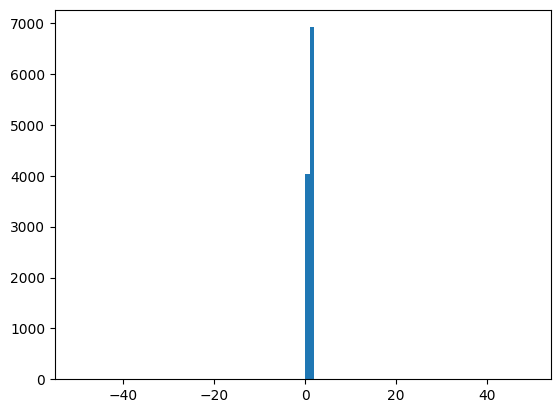

In [29]:
_, positionsGFP1, _ = wp.tilepin(reads_correct, GFP, thresh=0.03, verbose=True)
_, positionsGFP2, _ = wp.tilepin_v2(reads_correct, GFP, thresh=0.03, verbose=True)
plt.figure()
plt.hist(positionsGFP1 - positionsGFP2, bins=np.arange(-50, 50))
plt.show()
